In [27]:
import numpy as np
import matplotlib.pyplot as plt
import math
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from torch.autograd import grad
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR
from torch.autograd import gradcheck
torch.manual_seed(42)
import random
random.seed(0)
np.random.seed(0)

In [28]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
class Partitioned_RK:
    def __init__(self, f, butcher_tableau_1, butcher_tableau_2, c_1, c_2, b_1, b_2, h, iter):
        self.bt1 = butcher_tableau_1
        self.bt2 = butcher_tableau_2
        self.c1 = c_1
        self.c2 = c_2
        self.b1 = b_1
        self.b2 = b_2
        self.h = h
        self.f = f
        self.iter = iter
        
    def solve(self, p, q, p0, q0):
        if p0:
            shape = self.c1.shape[0]
            P = np.full(shape, (p+p0)/2)
            Q = np.full(shape, (q+q0)/2)
        else:
            P = np.zeros((self.c1.shape[0]))
            Q = np.zeros((self.c2.shape[0]))
        for iter in range(self.iter):
            for i in range(self.c1.shape[0]):
                curr_sum_p = p
                curr_sum_q = q
                for j in range(self.c1.shape[0]):
                    curr_sum_p += self.h * self.bt1[i, j] * self.f(np.array([P[j], Q[j]]))[0]
                    curr_sum_q += self.h * self.bt2[i, j] * self.f(np.array([P[j], Q[j]]))[1]
                P[i] = curr_sum_p
                Q[i] = curr_sum_q
        p_next = p
        q_next = q
        for i in range(self.c1.shape[0]):
            p_next += self.h * self.b1[i] * self.f(np.array([P[j], Q[j]]))[0]
            q_next += self.h * self.b2[i] * self.f(np.array([P[j], Q[j]]))[1]
        return p_next, q_next
    
    def step(self, p_curr, q_curr, p0 = None, q0 = None):
        p_next, q_next = self.solve(p_curr, q_curr, p0, q0)
        return np.array([p_next, q_next])

In [176]:
def mass_spring_hamiltonian(p, q):
    return 0.5 * (p**2 + q**2)

def mass_spring(p_0, q_0, t):
    return p_0*np.cos(t) - q_0*np.sin(t), p_0*np.sin(t) + q_0*np.cos(t)

num_samples = 1000
num_steps = 30
dataset = np.zeros((num_samples, num_steps, 3))


for sample in range(num_samples):

    # p0 = np.random.uniform(-1, 1)
    # q0 = np.random.uniform(0.5, 1.5) 
    y0 = np.random.rand(2)*2-1
    radius = np.random.rand()*0.9 + 0.1
    y0 = y0 / np.sqrt((y0**2).sum()) * radius
    p0 = y0[0]
    q0 = y0[0]

    p_values = np.zeros(num_steps)
    q_values = np.zeros(num_steps)
    h_values = np.zeros(num_steps)

    p = p0
    q = q0

    p_values[0] = p
    q_values[0] = q
    h_values[0] = mass_spring_hamiltonian(p,q)

    for i in range(1, num_steps):
        p, q = mass_spring(p0, q0, i)
        p_values[i] = p
        q_values[i] = q
        h_values[i] = mass_spring_hamiltonian(p, q)
    dataset[sample, :, 0] = p_values
    dataset[sample, :, 1] = q_values
    dataset[sample, :, 2] = h_values
# np.save("mass_spring_30.npy", dataset)

In [177]:
dataset = np.load("mass_spring_30.npy")
dataset.shape

(1000, 30, 3)

In [19]:
# def hamiltonian_dynamics(x):
#     return np.array([-x[1]*(x[0]**2 + 1), x[0]*(x[1]**2 + 1)])

def pendulum_hamiltonian(x):
    return 3 * (1 - np.cos(x[1])) + x[0]**2

def pendulum_dynamics(x):
    return -3 * np.sin(x[1]), 2*x[0]

def mass_spring_hamiltonian(x):
    return x[0]**2 + x[1]**2

def mass_spring_dynamics(x):
    return -2*x[1], 2*x[0]

def tao_dynamics(x):
    return np.array([-x[1]*(x[0]**2 + 1), x[0]*(x[1]**2 + 1)])

def tao_hamiltonian(x):
    return 0.5 * (x[0]**2 + 1)*(x[1]**2 + 1)


def generate_trajectory(num_samples, dt, T, prk, explicit_prk = None, init_coord = None, hamiltonian = mass_spring_hamiltonian):
    simulated_trajectory = np.zeros((num_samples, T, 3))
    timesteps = simulated_trajectory.shape[1]
    dt = dt
    for sample in tqdm(range(simulated_trajectory.shape[0])):
        # y0 = np.random.rand(2)*2-1
        # radius = np.random.rand()*0.9 + 0.1
        # y0 = y0 / np.sqrt((y0**2).sum()) * radius
        # p0 = y0[0]
        # q0 = y0[1]
        if init_coord:
            y0 = init_coord[sample]
            p0 = y0[0]
            q0 = y0[1]
        else:
            p0 = dataset[sample, 0, 0]
            q0 = dataset[sample, 0, 1]
        simulated_trajectory[sample, 0, 0] = p0
        simulated_trajectory[sample, 0, 1] = q0
        p = simulated_trajectory[sample, 0, 0]
        q = simulated_trajectory[sample, 0, 1]
        for time in range(1, timesteps):
            num_steps = int(1/dt)
            for _ in range(num_steps):
                p_init = None
                q_init = None
                # x = euler(np.array([p, q]), mass_spring_dynamics, dt)
                if explicit_prk:
                    x = explicit_prk.step(p, q)
                    p_init = x[0]
                    q_init = x[1]
                x = prk.step(p, q, p_init, q_init)
                p = x[0]
                q = x[1]
            simulated_trajectory[sample, time, 0] = p
            simulated_trajectory[sample, time, 1] = q
            simulated_trajectory[sample, time, 2] = hamiltonian(np.array([p, q]))
    return simulated_trajectory

In [20]:
def get_initial_coord(num_samples):
    dataset = []
    for sample in range(num_samples):
        y0 = np.random.rand(2)*2-1
        radius = np.random.rand()*0.9 + 0.1
        y0 = y0 / np.sqrt((y0**2).sum()) * radius
        dataset.append(y0)
    return dataset

init_coord = get_initial_coord(1000)

In [24]:
butcher_tableau = np.array([[0]])

c = np.array([0])

b = np.array([1])

iter = 1

h = 0.001

init_coord = init_coord
dynamics = mass_spring_dynamics
hamiltonian = mass_spring_hamiltonian

prk = Partitioned_RK(dynamics, butcher_tableau, butcher_tableau, c, c, b, b, h, 1)


euler_prk = generate_trajectory(num_samples = 1000, dt = h, T = 30, prk = prk, init_coord = init_coord, hamiltonian = hamiltonian)


100%|███████████████████████████████████████| 1000/1000 [06:10<00:00,  2.70it/s]


In [25]:
euler_prk.shape

(1000, 30, 3)

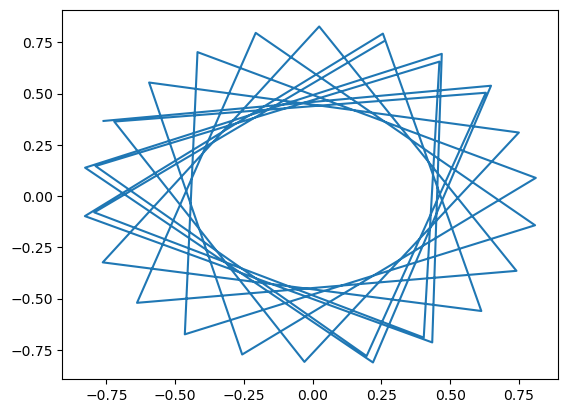

In [26]:
plt.plot(euler_prk[0, :, 0], euler_prk[0, :, 1])

In [338]:
butcher_tableau_1 = np.array(
                [[1/2, 0],
                [1/2, 0]])

butcher_tableau_2 = np.array(
                    [[0, 0],
                     [1/2, 1/2]])

c_1 = np.array([0, 1])

c_2 = np.array([0, 1])

b_1 = np.array([1/2, 1/2])

b_2 = np.array([1/2, 1/2])

h = 0.01


iter = 1

init_coord = None
dynamics = mass_spring_dynamics
hamiltonian = mass_spring_hamiltonian


prk = Partitioned_RK(dynamics, butcher_tableau_1, butcher_tableau_2, c_1, c_2, b_1, b_2, h, iter)

implicit_prk = generate_trajectory(num_samples = 1000, dt = h, T = 30, prk = prk, init_coord = init_coord, hamiltonian = hamiltonian)


100%|███████████████████████████████████████| 1000/1000 [00:43<00:00, 22.95it/s]


In [339]:
butcher_tableau_2 = np.array(
                    [[0, 0],
                     [1, 0]])


c_2 = np.array([0, 1])


b_2 = np.array([1/2, 1/2])

h = 0.01

iter = 1


init_coord = None
dynamics = mass_spring_dynamics
hamiltonian = mass_spring_hamiltonian

explicit_prk = Partitioned_RK(dynamics, butcher_tableau_2, butcher_tableau_2, c_2, c_2, b_2, b_2, h, iter)

# prk = Partitioned_RK(dynamics, butcher_tableau_2, butcher_tableau_2, c_2, c_2, b_2, b_2, h, iter)

predictor_prk = generate_trajectory(num_samples = 1000, dt = h, T = 30, prk = explicit_prk, explicit_prk = None, init_coord = init_coord, hamiltonian = hamiltonian)


100%|███████████████████████████████████████| 1000/1000 [01:16<00:00, 13.11it/s]


In [340]:
# butcher_tableau_1 = np.array(
#                 [[1/2, -1/2],
#                 [1/2, 1/2]])

butcher_tableau = np.array(
                    [[0, 0],
                     [1, 0]])

butcher_tableau_1 = np.array(
                [[1/2, 0],
                [1/2, 0]])

butcher_tableau_2 = np.array(
                    [[0, 0],
                     [1/2, 1/2]])


c_1 = np.array([0, 1])

c_2 = np.array([0, 1])

b_1 = np.array([1/2, 1/2])

b_2 = np.array([1/2, 1/2])

h = 0.01

iter = 1

init_coord = None
dynamics = mass_spring_dynamics
hamiltonian = mass_spring_hamiltonian


explicit_prk = Partitioned_RK(dynamics, butcher_tableau, butcher_tableau, c_2, c_2, b_2, b_2, h, iter)

prk = Partitioned_RK(dynamics, butcher_tableau_1, butcher_tableau_2, c_1, c_2, b_1, b_2, h, iter)

symplectic_prk = generate_trajectory(num_samples = 1000, dt = h, T = 30, prk = prk, explicit_prk = explicit_prk, init_coord = init_coord, hamiltonian = hamiltonian)


100%|███████████████████████████████████████| 1000/1000 [02:08<00:00,  7.80it/s]


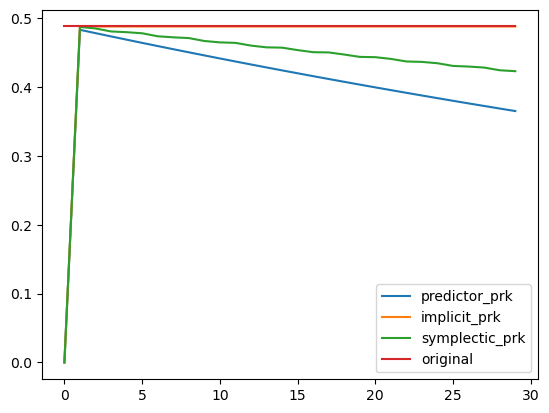

In [342]:
# plt.plot(euler_prk[0, :, 2], label = "euler")
plt.plot(predictor_prk[0, :, 2], label = "predictor_prk")
plt.plot(implicit_prk[0, :, 2], label = "implicit_prk")
plt.plot(symplectic_prk[0, :, 2], label = "symplectic_prk")
plt.plot(dataset[0, :, 2], label = "original")
plt.legend()
# plt.savefig("hamiltonian_plot.png")

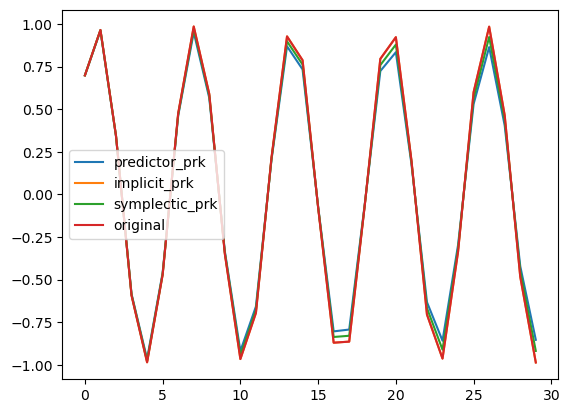

In [343]:
# plt.plot(euler_prk[0, :, 1], label = "euler")
plt.plot(predictor_prk[0, :, 1], label = "predictor_prk")
plt.plot(implicit_prk[0, :, 1], label = "implicit_prk")
plt.plot(symplectic_prk[0, :, 1], label = "symplectic_prk")
plt.plot(dataset[0, :, 1], label = "original")
plt.legend()
# plt.savefig("momentum_plot.png")

In [29]:
def hamiltonian_dynamics(x):
    return np.array([-x[1]*(x[0]**2 + 1), x[0]*(x[1]**2 + 1)])

def hamiltonian(p, q):
    return 0.5 * (p**2 + 1)*(q**2 + 1)

def euler_step(x, func, dt):
    return x + func(x)*dt

def leapfrog_step(x, func, dt):
    x[0] += 0.5 * func(x)[0] * dt
    x[1] += func(x)[1] * dt
    x[0] += 0.5 * func(x)[0] * dt
    return x

def predictor(x, func, dt):
    temp = x + dt * func(x)
    k1 = func(x)
    k2 = func(temp)
    return x + dt * 0.5 * (k1 + k2)

def corrector(x, x_, func, dt, iters = 1):
    p_half = x_[0]
    q = x_[1]
    for _ in range(iters):
        p_half = x[0] + dt * 0.5 * func(np.array([p_half, x[1]]))[0]
        q = x[1] + dt * 0.5 * (func(np.array([p_half, x[1]]))[1] + func(np.array([p_half, q]))[1])
        p = p_half + dt * 0.5 * func(np.array([p_half, q]))[0] 
    return np.array([p, q])

def predictor_corrector(x, func, dt, **kwargs):
    result = predictor(x, func, dt)
    result = corrector(x, result, func, dt, **kwargs)
    return result


integrator_dict = {
    'euler' : euler_step,
    'leapfrog' : leapfrog_step,
    'pc' : predictor_corrector
}

def generate_trajectory(num_samples, integrator, dt, T, **kwargs):
    simulated_trajectory = np.zeros((num_samples, T, 3))
    timesteps = simulated_trajectory.shape[1]
    dt = dt
    for sample in tqdm(range(simulated_trajectory.shape[0])):
        y0 = np.random.rand(2)*2-1
        radius = np.random.rand()*0.9 + 0.1
        y0 = y0 / np.sqrt((y0**2).sum()) * radius
        p0 = y0[0]
        q0 = y0[1]
        simulated_trajectory[sample, 0, 0] = p0
        simulated_trajectory[sample, 0, 1] = q0
        p = simulated_trajectory[sample, 0, 0]
        q = simulated_trajectory[sample, 0, 1]
        for time in range(1, timesteps):
            num_steps = int(1/dt)
            for _ in range(num_steps):
                x = integrator_dict[integrator](np.array([p, q]), hamiltonian_dynamics, dt, **kwargs)
                p = x[0]
                q = x[1]
            simulated_trajectory[sample, time, 0] = p
            simulated_trajectory[sample, time, 1] = q
            simulated_trajectory[sample, time, 2] = hamiltonian(p, q)
    return simulated_trajectory

In [30]:
euler_trajectory = generate_trajectory(1000, "euler", 0.001, 30)

100%|███████████████████████████████████████| 1000/1000 [01:44<00:00,  9.59it/s]


In [36]:
leapfrog_trajectory = generate_trajectory(1000, "euler", 0.001, 200)

100%|███████████████████████████████████████| 1000/1000 [11:46<00:00,  1.42it/s]


In [13]:
pc_trajectory = generate_trajectory(1000, "pc", 0.001, 30, iters = 1)

100%|███████████████████████████████████████| 1000/1000 [07:52<00:00,  2.12it/s]


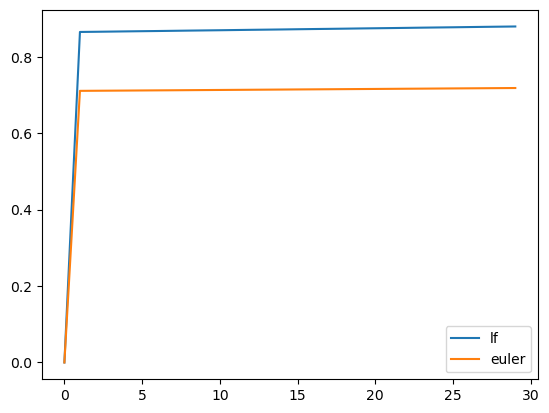

In [34]:
plt.plot(leapfrog_trajectory[0, :, 2], label = "lf")
plt.plot(euler_trajectory[0, :, 2], label = "euler")
plt.legend()

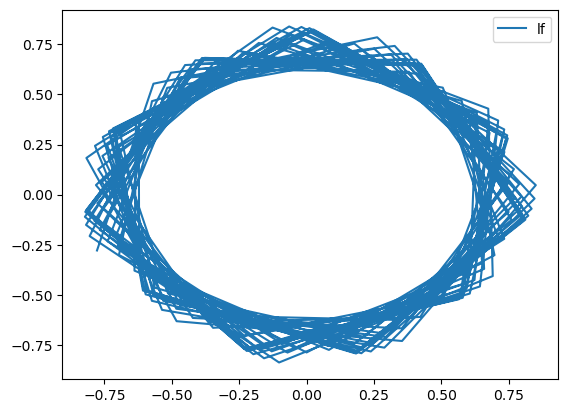

In [37]:
# plt.plot(pc_trajectory[0, :, 0], pc_trajectory[0, :, 1], label = "pc")
plt.plot(leapfrog_trajectory[0, :, 0], leapfrog_trajectory[0, :, 1], label = "lf")
# plt.plot(euler_trajectory[0, :, 0], euler_trajectory[0, :, 1], label = "euler")

plt.legend()

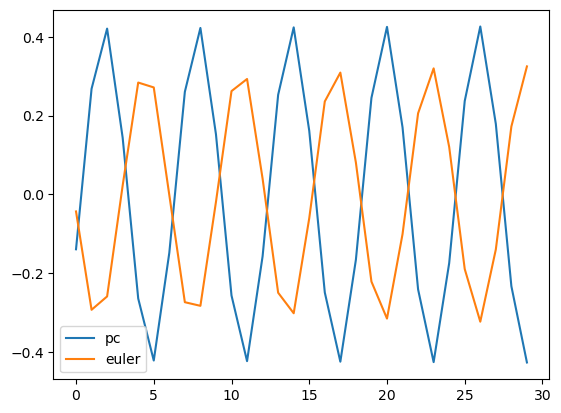

In [16]:
plt.plot(pc_trajectory[0, :, 1], label = "pc")
plt.plot(euler_trajectory[0, :, 1], label = "euler")

plt.legend()